# Assignment 4

Firstly, we load numerical and plotting libraries:

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt


# For reproducibility
SEED = 7
rng = np.random.default_rng(SEED)

## Implementing periodic boundary conditions (PBC) and minimum‑image function

Our position vectors ${\bf r}$ are defined within the domain $[0,L]^d$.

In order to ensure that it is always so, and that distances are computed in an appropriate way, we introduce two functions:
* One that brings back any position vector ${\bf r}$ to the domain $[0,L]^d$;
* One that, when computing differences such as ${\bf r}_1 - {\bf r}_2$ always takes the minimal one. 

In [2]:
def wrap_pos(r, L):
    """Wrap positions into [0, L) under PBC. r: (N,d) array."""
    return np.mod(r, L)

def min_image(dx, L):
    """Apply minimum image to displacement vectors dx."""
    return dx - L * np.round(dx / L)

## Lennard–Jones potential and inter-molecular forces

We consider the Lennard-Jones potential

$$ V_{\mathrm{LJ}}(r)=4\varepsilon\Big[\big(\tfrac{r_0}{r}\big)^{12}-\big(\tfrac{r_0}{r}\big)^{6}\Big]. $$

The associated inter-molecular radial component of the forces are then computed via

$$ F(r)=- \frac{\mathrm{d}V_{\mathrm{LJ}}}{\mathrm{d}r} = \frac{24 \varepsilon}{r_0} \left[ 2 \big(\tfrac{r_0}{r}\big)^{13}-\big(\tfrac{r_0}{r}\big)^{7} \right] , $$

Thus, the force vectors are 

$$ {\bf F} = \frac{24 \varepsilon}{r_0^2} \left[ 2 \big(\tfrac{r_0}{r}\big)^{14}-\big(\tfrac{r_0}{r}\big)^{8} \right] {\bf r} \,. $$

> We will also introduce a 'mask' such that the interactions are null if the distance between two molecules is greater than a cutoff distance $r_c$. This may be helpful to improve the efficiency of the code.

> We will work in reduced units, 'forgetting' $\varepsilon$, $r_0$.

We then define a function that outputs both the potentials, and the forces for the molecules: 

In [3]:
def lj_forces_energy(r, rc, L, tiny=0.01, r_min_cap=1.2):
    """
    Compute Lennard–Jones forces and potential energy using a plain radial cutoff.
    Reduced units (epsilon = r0 = m = 1).

    Parameters
    ----------
    r  : (N, d) ndarray
        Positions.
    rc : float
        Cutoff radius; pairs with r >= rc are ignored.
    L  : float
        Box length (square/cubic).

    Returns
    -------
    F : (N, d) ndarray
        Forces on each particle.
    U : float
        Total potential energy (pairs counted once).
    """
    N, d = r.shape
    F = np.zeros_like(r)
    U = 0.0
    rc2 = rc * rc

    for j in range(N-1):
        # minimum-image displacements from j to partners k>j
        dx = r[j+1:] - r[j]            # (N-j-1, d)
        dx = min_image(dx, L)
        r2 = np.sum(dx*dx, axis=1)     # (N-j-1,)

        # Keep only safe, interacting pairs
        mask = (r2 < rc2) & (r2 > tiny)
        if not np.any(mask):
            continue

        # --- APPLY MASK BEFORE ANY INVERSES ---
        dxm = dx[mask]                 # (M,d)
        r2m = r2[mask]                 # (M,)

        # Optional short-range cap (after masking)
        if r_min_cap is not None:
            r2m = np.maximum(r2m, r_min_cap**2)

        inv_r2  = 1.0 / r2m            # r^{-2}
        inv_r6  = inv_r2**3            # r^{-6}
        inv_r12 = inv_r6**2            # r^{-12}

        # Potential energy: sum over masked pairs
        U += np.sum(4.0*(inv_r12 - inv_r6))

        # Forces: F_jk = 24*(2 r^{-14} - r^{-8}) * dx
        f_over_r = 24.0*(2.0*inv_r12*inv_r2 - inv_r6*inv_r2)   # (M,)
        fij = f_over_r[:, None] * dxm                          # (M,d)

        # Accumulate on particle j
        F[j] += np.sum(fij, axis=0)

        # Equal-and-opposite on partners k>j, using absolute indices (robust)
        k_idx = np.nonzero(mask)[0] + (j + 1)
        F[k_idx] -= fij

    return F, U

## Choosing initial conditions

We choose the initial conditions as follows:

- **Positions:** uniform in $[0,L)$, rejecting proposals with inter‑particle distance $r \le 1$ (in reduced units).  
- **Velocities:** sample each component from a Gaussian distribution $\mathcal{N}(0, \sigma^2)$ and **subtract the centre‑of‑mass (COM)** velocity to enforce zero total momentum -- useful for later!

In [ ]:
def init_positions_no_overlap(N, d, L, min_dist=1.10, max_tries=200000):
    """
    Place N particles uniformly at random in a periodic box, rejecting placements
    that come within 'min_dist' (in reduced units) of any already-placed particle.

    Parameters
    ----------
    N : int
        Number of particles.
    d : int
        Spatial dimension (2 or 3 typically).
    L : float
        Box length (assumes a cubic/square box of side L with PBC).
    min_dist : float, optional
        Minimum allowed (Euclidean) separation under PBC via minimum-image.
        If a proposed particle is <= min_dist from any existing one, it is rejected.
    max_tries : int, optional
        Hard cap on total proposal attempts to avoid infinite loops at high density.

    Returns
    -------
    r : (N, d) ndarray
        Positions in [0, L) (component-wise), with no overlaps closer than min_dist.
    """
    r = np.empty((N, d))  # output array for accepted positions
    placed = 0            # how many particles have been successfully placed
    tries = 0             # total number of proposals (accepted + rejected)

    while placed < N:
        # Propose a candidate uniformly in the primary box [0, L)^d
        candidate = rng.uniform(0.1*L, 0.9*L, size=d)

        # Check candidate against all already-placed particles
        ok = True
        for j in range(placed):
            # Minimum-image displacement to particle j (shortest vector under PBC)
            dx = min_image(candidate - r[j], L)
            # Reject if too close (<= min_dist)
            if np.linalg.norm(dx) <= min_dist:
                ok = False
                break  # no need to check further neighbours

        # Accept if it passed all checks; otherwise loop and try a new candidate
        if ok:
            r[placed] = candidate
            placed += 1

        # Bookkeeping and safety stop
        tries += 1
        if tries > max_tries:
            raise RuntimeError(
                "Could not place particles without overlap. "
                "Try smaller N, smaller min_dist, or larger L."
            )

    return r


def init_velocities_gaussian(N, d, sigma=0.2):
    """
    Draw initial velocities from an i.i.d. Gaussian and enforce zero total momentum.

    Parameters
    ----------
    N : int
        Number of particles.
    d : int
        Spatial dimension.
    sigma : float, optional
        Standard deviation per component (sets initial kinetic temperature scale).

    Returns
    -------
    v : (N, d) ndarray
        Velocities with mean per component exactly zero (COM at rest).
    """
    # Independent normal components ~ N(0, sigma^2)
    v = rng.normal(0.0, sigma, size=(N, d))

    # Subtract the centre-of-mass velocity to enforce total momentum = 0
    v -= np.mean(v, axis=0)

    return v


## Implementing velocity-Verlet and leap-frog methods

As we did in Assignment 3 to study the motion of a three-body system, we can set up a velocity-Verlet method to study the motion of the molecules.
Recall that the velocity-Verlet method updates the quantities as follows:

$$
			\mathbf{r}_j^{\,n+1}=\mathbf{r}_j^{\,n}+\Delta t\,\mathbf{v}_j^{\,n}+\tfrac12\Delta t^2\,\mathbf{a}_j^{\,n},\quad
			\mathbf{v}_j^{\,n+1}=\mathbf{v}_j^{\,n}+\tfrac12\Delta t\big(\mathbf{a}_j^{\,n}+\mathbf{a}_j^{\,n+1}\big),
$$

> Since it will be useful later on, within the function below, we also compute (and then output) the energies and momenta of the molecules.

In [ ]:
def velocity_verlet(r0, v0, dt, steps, L, rc, store_traj=True):
    """
    Advance an LJ MD system with the velocity-Verlet integrator.

    Scheme:
        r_{n+1} = r_n + Δt v_n + (Δt^2/2) a_n
        a_{n+1} = a(r_{n+1})
        v_{n+1} = v_n + (Δt/2) (a_n + a_{n+1})

    Parameters / Returns
    --------------------
    Same as leapfrog().
    """
    r = r0.copy()
    v = v0.copy()

    # Initial forces/energy at t = 0
    F, U = lj_forces_energy(r, rc, L)

    traj = [r.copy()] if store_traj else None
    E_list, P_list = [], []

    for _ in range(steps):
        # (1) Drift with current v and a_n, then wrap into box
        r = wrap_pos(r + dt * v + 0.5 * dt * dt * F, L)

        # (2) New forces/energy at updated positions
        F_new, U = lj_forces_energy(r, rc, L)

        # (3) Velocity update using average acceleration
        v = v + 0.5 * dt * (F + F_new)
        F = F_new  # advance force for next step

        # --- Diagnostics at integer time ---
        K = 0.5 * np.sum(v * v)
        P = np.sum(v, axis=0)
        E_list.append(K + U)
        P_list.append(P.copy())

        if store_traj:
            traj.append(r.copy())

    return (np.array(traj) if store_traj else None,
            np.array(E_list),
            np.array(P_list))


We can similarly implement the *leap-frog* method.
The leap-frog method updates the quantities as follows:

\begin{align}
			\mathbf v^{\,n+\tfrac12} &= \mathbf v^{\,n} + \frac{\Delta t}{2}\,\mathbf a^{\,n},\\
			\mathbf r^{\,n+1}        &= \mathbf r^{\,n} + \Delta t\,\mathbf v^{\,n+\tfrac12},\\
			\mathbf a^{\,n+1}        &= \frac{1}{m}\,\mathbf F \big(\mathbf r^{\,n+1}\big),\\
			\mathbf v^{\,n+1}        &= \mathbf v^{\,n+\tfrac12} + \frac{\Delta t}{2}\,\mathbf a^{\,n+1}.
		\end{align}


In [ ]:
def leapfrog(r0, v0, dt, steps, L, rc, store_traj=True):
    """
    Advance an LJ MD system with the leap-frog scheme (staggered in time).

    Scheme (kick-drift-kick, with half-step velocities):
        1) Given a(t_0), form v(t_0 + Δt/2) = v(t_0) + (Δt/2) a(t_0)
        2) Drift: r(t_0 + Δt) = r(t_0) + Δt * v(t_0 + Δt/2)
        3) Compute a(t_0 + Δt) from the new positions
        4) Kick to integer time (for diagnostics): v(t_0 + Δt) = v(t_0 + Δt/2) + (Δt/2) a(t_0 + Δt)
        5) Prepare next half-step velocity: v(t_0 + 3Δt/2) = v(t_0 + Δt/2) + Δt * a(t_0 + Δt)

    Parameters
    ----------
    r0, v0 : (N, d) arrays
        Initial positions and velocities (reduced units).
    dt : float
        Time step.
    steps : int
        Number of integration steps.
    L : float
        Box length for PBC (square/cubic).
    rc : float
        Lennard–Jones cutoff (plain cutoff; forces/energy from lj_forces_energy).
    store_traj : bool
        If True, store positions at t=0 and after each step (length steps+1).

    Returns
    -------
    traj : (steps+1, N, d) array or None
        Positions along the trajectory (None if store_traj=False).
    E : (steps,) array
        Total energy per step, E = K + U, evaluated at integer times.
    P : (steps, d) array
        Total momentum vector per step, evaluated at integer times.
    """
    r = r0.copy()
    v = v0.copy()

    # Initial forces/energy at t = 0
    F, U = lj_forces_energy(r, rc, L)

    # Half-step velocity for leap-frog staggering: v(t0 + dt/2)
    v_half = v + 0.5 * dt * F

    # Optional trajectory storage (include initial positions)
    traj = [r.copy()] if store_traj else None
    E_list, P_list = [], []

    for _ in range(steps):
        # (1) Drift: advance positions with half-step velocities; then wrap into box
        r = wrap_pos(r + dt * v_half, L)

        # (2) Compute forces at the new positions (accelerations at t + dt)
        F, U = lj_forces_energy(r, rc, L)

        # (3) Kick to *integer* time to get v(t + dt) for diagnostics
        v = v_half + 0.5 * dt * F

        # --- Diagnostics at integer time ---
        K = 0.5 * np.sum(v * v)       # kinetic energy (m = 1 in reduced units)
        P = np.sum(v, axis=0)         # total momentum vector
        E_list.append(K + U)          # total energy K + U
        P_list.append(P.copy())

        # (4) Prepare next half-step: v(t + 3Δt/2) = v(t + Δt/2) + Δt a(t + Δt)
        v_half = v_half + dt * F

        if store_traj:
            traj.append(r.copy())

    return (np.array(traj) if store_traj else None,
            np.array(E_list),
            np.array(P_list))


def velocity_verlet(r0, v0, dt, steps, L, rc, store_traj=True):
    """
    Advance an LJ MD system with the velocity-Verlet integrator.

    Scheme:
        r_{n+1} = r_n + Δt v_n + (Δt^2/2) a_n
        a_{n+1} = a(r_{n+1})
        v_{n+1} = v_n + (Δt/2) (a_n + a_{n+1})


    Parameters / Returns
    --------------------
    Same as leapfrog().
    """
    r = r0.copy()
    v = v0.copy()

    # Initial forces/energy at t = 0
    F, U = lj_forces_energy(r, rc, L)

    traj = [r.copy()] if store_traj else None
    E_list, P_list = [], []

    for _ in range(steps):
        # (1) Drift with current v and a_n, then wrap into box
        r = wrap_pos(r + dt * v + 0.5 * dt * dt * F, L)

        # (2) New forces/energy at updated positions
        F_new, U = lj_forces_energy(r, rc, L)

        # (3) Velocity update using average acceleration
        v = v + 0.5 * dt * (F + F_new)
        F = F_new  # advance force for next step

        # --- Diagnostics at integer time ---
        K = 0.5 * np.sum(v * v)
        P = np.sum(v, axis=0)
        E_list.append(K + U)
        P_list.append(P.copy())

        if store_traj:
            traj.append(r.copy())

    return (np.array(traj) if store_traj else None,
            np.array(E_list),
            np.array(P_list))


## Plotting functions and helpers

We now introduce some `helper' functions that will be useful to extract some important physical quantities:

- `time_vector(t_max, steps)`: Returns a length-`steps` array from `0` to `t_max` (inclusive) for plotting diagnostics sampled once per step.

- `momentum_norm(P)`: Converts a `(steps, d)` momentum history into its Euclidean norm `|P(t)|` at each step.


In [ ]:
def time_vector(t_max, steps):
    """
    Build a time array compatible with diagnostics sampled once per step.

    Parameters
    ----------
    t_max : float
        Final time displayed on the x-axis.
    steps : int
        Number of samples (e.g., energy values). Typically equals the number of
        integration steps you performed.

    Returns
    -------
    t : (steps,) ndarray
        Linearly spaced times from 0 to t_max *inclusive*.

    """
    return np.linspace(0.0, t_max, steps)


def momentum_norm(P):
    """
    Compute the Euclidean norm of the total momentum vector at each sample.

    Parameters
    ----------
    P : (steps, d) ndarray
        Total momentum vector at each sampled time (sum over particles).

    Returns
    -------
    pnorm : (steps,) ndarray
        |P(t)| for each time sample.
    """
    return np.linalg.norm(P, axis=1)



...and we also introduce several plotting functions:

- `plot_trajectories(traj, L, title)`: 2D path plot of all particles within `[0, L]×[0, L]` (requires stored trajectory).

- `plot_energy(t, E)`: Line plot of total energy \(E(t)\); useful to spot drift/oscillations.

- `plot_rel_energy(t, E)`: Plots relative drift \((E-E_0)/|E_0|\) to highlight long-term energy stability.

- `plot_momentum_norm(t, P)`: Plots `|P(t)|` to check total-momentum conservation.

In [ ]:
def plot_trajectories(traj, L, title="Trajectories (2D, PBC box)"):
    """
    Plot 2D particle trajectories inside the periodic box.

    Parameters
    ----------
    traj : (T, N, 2) ndarray or None
        Stored positions for T time points. If None, a message is printed.
    L : float
        Box length; sets plot limits to [0, L] in both axes.
    title : str
        Figure title.

    """
    if traj is None:
        print("No trajectories stored (store_traj=False).")
        return
    fig, ax = plt.subplots()
    for j in range(traj.shape[1]):               # loop over particles
        ax.plot(traj[:, j, 0], traj[:, j, 1], linewidth=0.8)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(0, L); ax.set_ylim(0, L)
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title(title)
    plt.show()


def plot_energy(t, E):
    """
    Plot total energy vs time.

    Parameters
    ----------
    t : (steps,) ndarray
        Time vector (typically from time_vector).
    E : (steps,) ndarray
        Total energy at each time sample.
    """
    fig, ax = plt.subplots()
    ax.plot(t, E, linewidth=1.0)
    ax.set_xlabel("t")
    ax.set_ylabel("E(t)")
    ax.set_title("Total energy vs time")
    plt.show()


def plot_rel_energy(t, E):
    """
    Plot relative energy drift (E - E0) / |E0| vs time.

    Parameters
    ----------
    t : (steps,) ndarray
        Time vector.
    E : (steps,) ndarray
        Total energy per sample.

    """
    fig, ax = plt.subplots()
    dE = (E - E[0]) / abs(E[0])
    ax.plot(t, dE, linewidth=1.0)
    ax.set_xlabel("t")
    ax.set_ylabel("(E−E0)/E0")
    ax.set_title("Relative energy drift")
    plt.show()


def plot_momentum_norm(t, P):
    """
    Plot the norm of total momentum vs time.

    Parameters
    ----------
    t : (steps,) ndarray
        Time vector.
    P : (steps, d) ndarray
        Total momentum vector at each time sample.
    """
    fig, ax = plt.subplots()
    ax.plot(t, momentum_norm(P), linewidth=1.0)
    ax.set_xlabel("t")
    ax.set_ylabel("|P(t)|")
    ax.set_title("Total momentum norm")
    plt.show()


## Concrete tests

We are now finally ready to perform concrete tests!
As suggested in the Assignment text, let us take the following data:

- Dimensions: **d = 2**  
- Particles: **N = 20**  
- Box length: **L = 10** (in units of $r_0$)  
- Total time: **t\_max = 10**  
- Steps: **n\_steps = 5000** (so $\Delta t = t_{\max}/(n-1)$)  
- Cutoff: **r\_c = 2.5**  

Below, we will switch `integrator` between `"vv"` (velocity‑Verlet) and `"lf"` (leap‑frog), and eventually toggle `store_traj` according to whether we wish to store them or not.


In [9]:

# --- Parameters ---
d = 2
N = 20
L = 10.0
t_max = 10.0
n_steps = 5000
dt = t_max / (n_steps - 1)
rc = 2.5

integrator = "vv"   # "vv" (velocity‑Verlet) or "lf" (leap‑frog)
store_traj = True   # set False for memory‑efficient run

# --- Initial conditions ---
r0 = init_positions_no_overlap(N, d, L, min_dist=0.5)
v0 = init_velocities_gaussian(N, d, sigma=0.1)  # zero COM enforced

# --- Run ---
if integrator == "lf":
    traj, E, P = velocity_verlet(r0, v0, dt, n_steps, L, rc, store_traj=store_traj)
else:
    traj, E, P = leapfrog(r0, v0, dt, n_steps, L, rc, store_traj=store_traj)

t = time_vector(t_max, len(E))


# --- Some quick checks (Energy should 'roughly' be a constant, and the momentum zero) ---
print(f"Integrator: {integrator}, N={N}, d={d}, L={L}, dt={dt:.5f}, rc={rc}")
print(f"Energy drift (min/mean/max of (E−E0)/|E0|): "
      f"{np.min((E-E[0])/abs(E[0])):.3e} / {np.mean((E-E[0])/abs(E[0])):.3e} / {np.max((E-E[0])/abs(E[0])):.3e}")
print(f"|P|(min/mean/max): {momentum_norm(P).min():.3e} / {momentum_norm(P).mean():.3e} / {momentum_norm(P).max():.3e}")


Integrator: vv, N=20, d=2, L=10.0, dt=0.00200, rc=2.5
Energy drift (min/mean/max of (E−E0)/|E0|): 0.000e+00 / 1.311e+00 / 1.689e+00
|P|(min/mean/max): 7.729e-17 / 5.639e-15 / 1.672e-14


Firstly, we plot the trajectories in the 2D square of side length $L$:

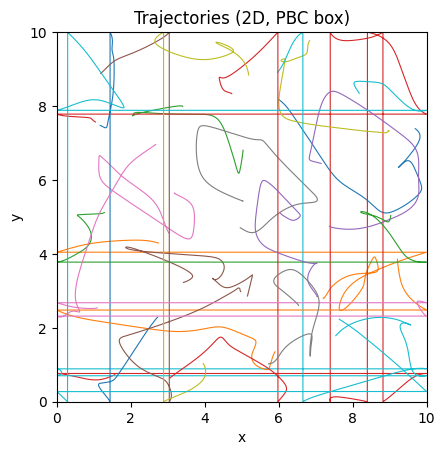

In [10]:
plot_trajectories(traj, L)

Then, we plot the norm of the total momentum:

> Notice that our velocities are initialised in the center of mass. Hence, we should expect that $P \simeq 0$!

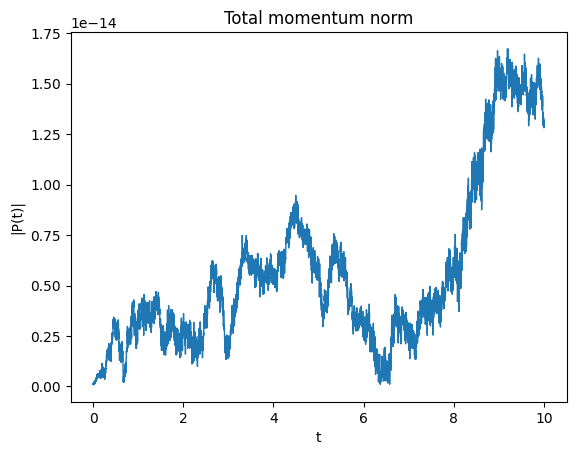

In [11]:
plot_momentum_norm(t, P)

...and the energy and the relative change of the energy are given by:

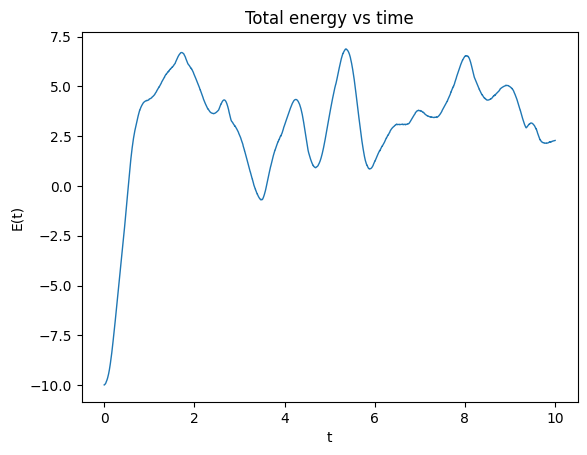

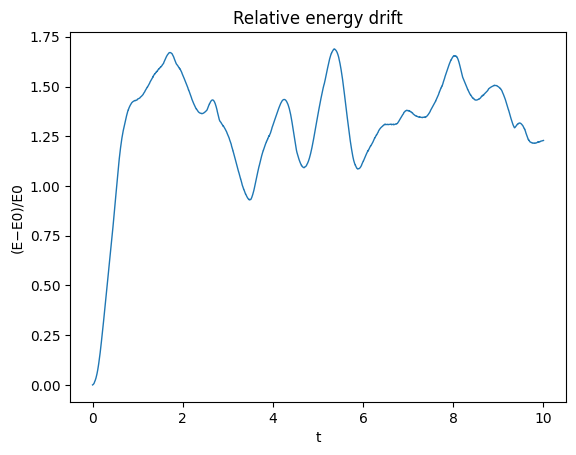

In [12]:
plot_energy(t, E)
plot_rel_energy(t, E)

## Comparison between velocity–Verlet and leap–frog method

Here we run **both** integrators from the **same initial conditions** and overlay the plots:
- 2D trajectories — all particles of one integrator share the same colour.
- Total energy $E(t)$
- Relative energy drift $(E-E_0)/|E_0|$
- Momentum norm $|\mathbf P(t)|$


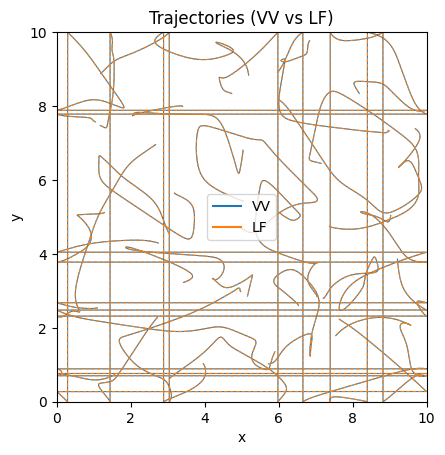

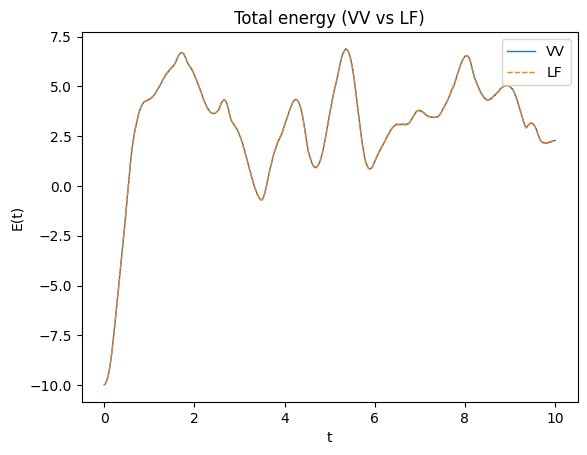

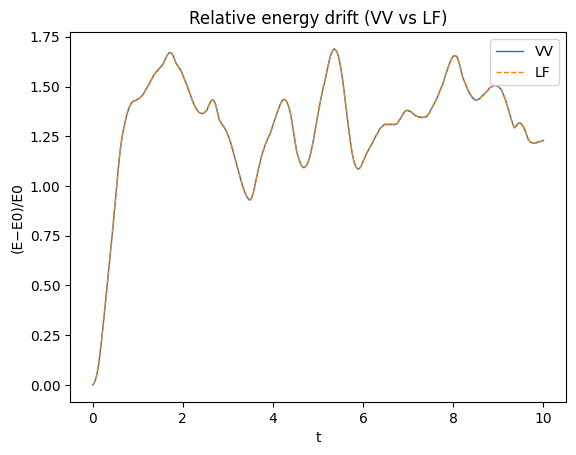

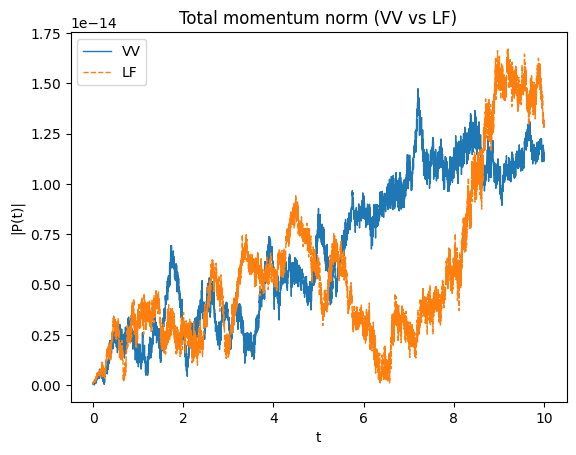

In [13]:
# --- Overlay helpers ---
def plot_overlay_trajectories(traj_vv, traj_lf, L, colors=('C0','C1')):
    """Overlay 2D trajectories for VV and LF. One colour per integrator."""
    if traj_vv is None or traj_lf is None:
        print("Need trajectories from both integrators (set store_traj=True).")
        return
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    # VV (first colour)
    for j in range(traj_vv.shape[1]):
        ax.plot(traj_vv[:, j, 0], traj_vv[:, j, 1], linewidth=0.8, alpha=0.95, color=colors[0])
    # LF (second colour)
    for j in range(traj_lf.shape[1]):
        ax.plot(traj_lf[:, j, 0], traj_lf[:, j, 1], linewidth=0.8, linestyle='dashed', alpha=0.95, color=colors[1])
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(0, L); ax.set_ylim(0, L)
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title("Trajectories (VV vs LF)")
    ax.legend(handles=[plt.Line2D([0],[0],color=colors[0],label='VV'),
                       plt.Line2D([0],[0],color=colors[1],label='LF')],
              loc='best')
    plt.show()

def plot_overlay_energy(t_vv, E_vv, t_lf, E_lf):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.plot(t_vv, E_vv, linewidth=1.0, label="VV")
    ax.plot(t_lf, E_lf, linestyle='dashed', linewidth=1.0, label="LF")
    ax.set_xlabel("t"); ax.set_ylabel("E(t)")
    ax.set_title("Total energy (VV vs LF)")
    ax.legend()
    plt.show()

def plot_overlay_rel_energy(t_vv, E_vv, t_lf, E_lf):
    import numpy as np, matplotlib.pyplot as plt
    eps = 1e-16
    dE_vv = (E_vv - E_vv[0]) / (abs(E_vv[0]) + eps)
    dE_lf = (E_lf - E_lf[0]) / (abs(E_lf[0]) + eps)
    fig, ax = plt.subplots()
    ax.plot(t_vv, dE_vv, linewidth=1.0, label="VV")
    ax.plot(t_lf, dE_lf, linestyle='dashed', linewidth=1.0, label="LF")
    ax.set_xlabel("t"); ax.set_ylabel("(E−E0)/E0")
    ax.set_title("Relative energy drift (VV vs LF)")
    ax.legend()
    plt.show()

def plot_overlay_momentum_norm(t_vv, P_vv, t_lf, P_lf):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.plot(t_vv, momentum_norm(P_vv), linewidth=1.0, label="VV")
    ax.plot(t_lf, momentum_norm(P_lf), linestyle='dashed', linewidth=1.0, label="LF")
    ax.set_xlabel("t"); ax.set_ylabel("|P(t)|")
    ax.set_title("Total momentum norm (VV vs LF)")
    ax.legend()
    plt.show()

# --- Run both integrators from identical initial conditions ---
# Make explicit copies to ensure identical starts
base_r = r0.copy()
base_v = v0.copy()

# Always store trajectories for this comparison
traj_vv, E_vv, P_vv = velocity_verlet(base_r, base_v, dt, n_steps, L, rc, store_traj=True)
traj_lf, E_lf, P_lf = leapfrog(base_r, base_v, dt, n_steps, L, rc, store_traj=True)

# Build time vectors (same length if steps are equal)
t_vv = time_vector(t_max, len(E_vv))
t_lf = time_vector(t_max, len(E_lf))

# --- Plots ---
plot_overlay_trajectories(traj_vv, traj_lf, L)
plot_overlay_energy(t_vv, E_vv, t_lf, E_lf)
plot_overlay_rel_energy(t_vv, E_vv, t_lf, E_lf)
plot_overlay_momentum_norm(t_vv, P_vv, t_lf, P_lf)
